# SAMD9L
[ataxia-pancytopenia syndrome (ATXPC)](https://omim.org/entry/159550) is caused by heterozygous mutation in the SAMD9L gene. 

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1.dev0


# SAMD9L
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SAMD9L.

In [2]:
gene_symbol = 'SAMD9L'
mane_tx_id = 'NM_152703.5'
mane_protein_id = 'NP_689916.2' # sterile alpha motif domain-containing protein 9-like

### Phenopackets
We loaded a cohort of 22 phenopackets representing published descriptions of individuals with pathogenic variants in ASPM diagnosed with MCPH5.
TODO UPDATE

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.20'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')

Loaded 21 phenopackets


In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 21/21 [00:00<00:00, 1785.43individuals/s]
Loaded 21 individuals
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #1
    phenotype-features
      #1
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #4
    phenotype-features
      #2
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #10
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
      #1
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #15
    phenotype-features
      #1
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_ele

# Explorative analysis


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Thrombocytopenia,HP:0001873,19
Neutropenia,HP:0001875,16
Pancytopenia,HP:0001876,12
Myelodysplasia,HP:0002863,11
Anemia,HP:0001903,10
Bone marrow hypocellularity,HP:0005528,9
Nystagmus,HP:0000639,8
Recurrent infections,HP:0002719,8
Unsteady gait,HP:0002317,6
Increased mean corpuscular volume,HP:0005518,6


/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_6137/3488743506.py:7: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


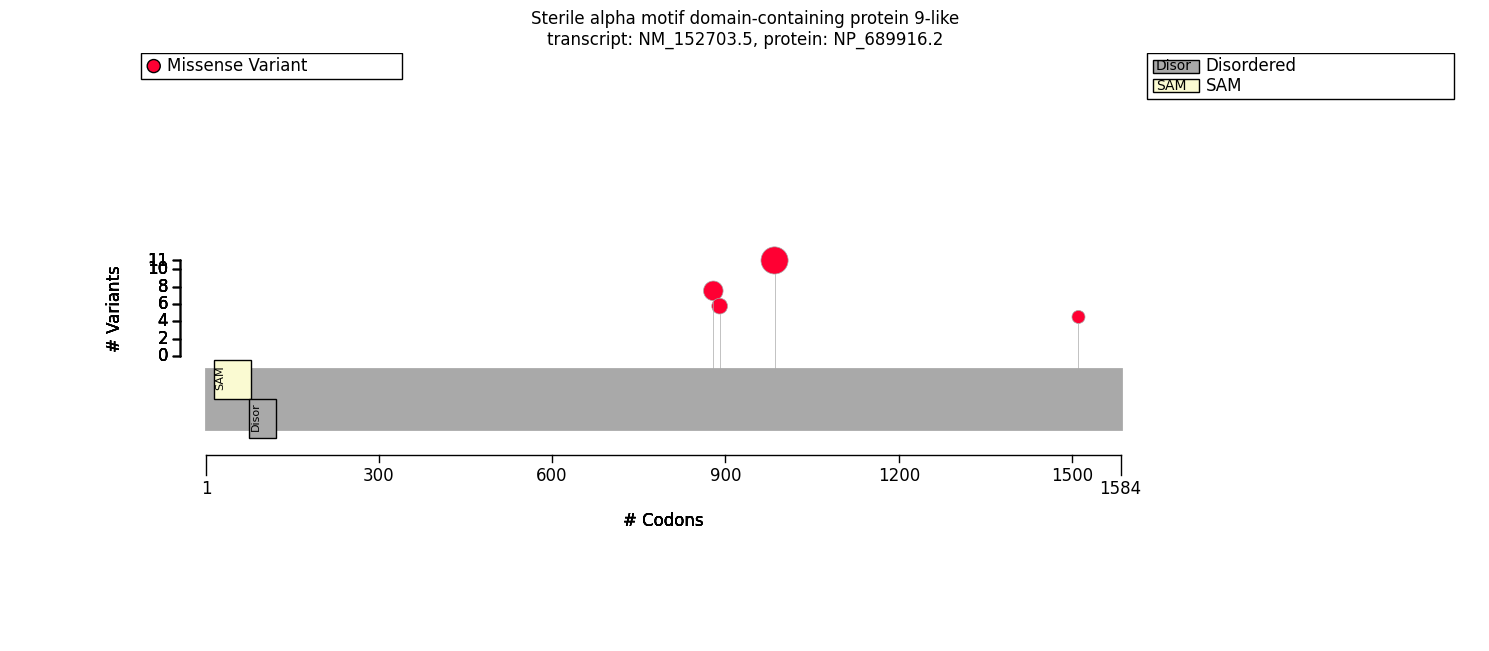

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

# Strategy

In [ ]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [12]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

n_term = VariantPredicates.region(region=Region(0, 950), tx_id=mane_tx_id)
nterm_predicate = monoallelic_predicate(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N Term",
    b_label="other")

In [14]:
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=nterm_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Code,Reason,Count
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,45
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,59


In [15]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       N Term          other  \
                                                    Count Percent  Count   
Attention deficit hyperactivity disorder [HP:00...    3/3    100%    0/6   
Anemia [HP:0001903]                                   5/5    100%   5/11   
Bone marrow hypocellularity [HP:0005528]              3/4     75%    6/6   
Thrombocytopenia [HP:0001873]                         8/8    100%  11/13   
Pancytopenia [HP:0001876]                             5/5    100%    7/9   
Neutropenia [HP:0001875]                              6/6    100%  10/12   
Myelodysplasia [HP:0002863]                           2/2    100%    9/9   
Abnormal platelet count [HP:0011873]                  8/8    100%  11/11   
Abnormal neutrophil count [HP:0011991]                6/6    100%  10/10   
Abnormal granulocyte morphology [HP:0001911]          6/6    100%  10/10   
Recurrent infections [HP:0002719]                     3/3    100%    5/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Attention deficit hyperactivity disorder [HP:00...      0%           0.130952   
Anemia [HP:0001903]                                    45%           0.513736   
Bone marrow hypocellularity [HP:0005528]              100%           0.970588   
Thrombocytopenia [HP:0001873]                          85%           0.970588   
Pancytopenia [HP:0001876]                              78%           0.970588   
Neutropenia [HP:0001875]                               83%           0.970588   
Myelodysplasia [HP:0002863]                           100%           1.000000   
Abnormal platelet count [HP:0011873]                  100%           1.000000   
Abnormal neutrophil count [HP:0011991]                100%           1.000000   
Abnormal granulocyte morphology [HP:0001911]          100%           1.000000   
Recurrent infections [HP:0002719]                      83%           1.000000   

Allele group                                                  
                                                    p values  
Attention deficit hyperactivity disorder [HP:00...  0.011905  
Anemia [HP:0001903]                                 0.093407  
Bone marrow hypocellularity [HP:0005528]            0.400000  
Thrombocytopenia [HP:0001873]                       0.504762  
Pancytopenia [HP:0001876]                           0.505495  
Neutropenia [HP:0001875]                            0.529412  
Myelodysplasia [HP:0002863]                         1.000000  
Abnormal platelet count [HP:0011873]                1.000000  
Abnormal neutrophil count [HP:0011991]              1.000000  
Abnormal granulocyte morphology [HP:0001911]        1.000000  
Recurrent infections [HP:0002719]                   1.000000